In [2]:
import ffn 
from empyrical import alpha_beta
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
import pandas as pd

In [3]:
fname = 'DATA 20200917_NOFS.xlsx'
df_INFO   = pd.read_excel(fname,sheet_name='INFO')

In [4]:
df_PRICES = pd.read_excel(fname,sheet_name='PRICES')
colnames  = df_PRICES.columns.values
colnames[0] = 'Date'
df_PRICES.columns = colnames
df_SIZES  = pd.read_excel(fname,sheet_name='SIZE')
colnames  = df_SIZES.columns.values
colnames[0] = 'Date'
df_SIZES.columns = colnames
df_PtB    = pd.read_excel(fname,sheet_name='PRICE TO BOOK')
colnames  = df_PtB.columns.values
colnames[0] = 'Date'
df_PtB.columns = colnames

df_PRICES['Date'] = pd.to_datetime(df_PRICES['Date'])
df_SIZES['Date']  = pd.to_datetime(df_SIZES['Date'])
df_PtB['Date']    = pd.to_datetime(df_PtB['Date'])

df_PRICES = df_PRICES.set_index('Date')
df_SIZES = df_SIZES.set_index('Date')
df_PtB = df_PtB.set_index('Date')

In [5]:
# example
df_PRICES.iloc[:3,:6]

,BT.A-GB,CCL-GB,MKS-GB,BARC-GB,ITRK-GB,BRBY-GB
Date,,,,,,
2018-12-31,100.00000,100.000000,100.00000,100.00000,100.000000,100.00000
2019-01-02,100.41382,101.683780,99.94125,99.72475,99.971680,99.04486
2019-01-03,100.11307,98.434883,100.88558,99.10764,95.307976,92.87219


In [27]:
# Step 1: Convert prices into returns
Returns = np.log(df_PRICES / np.roll(df_PRICES.values,1,axis=0))
Returns = Returns.iloc[1:]
Returns.iloc[:3,:6]

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


,BT.A-GB,CCL-GB,MKS-GB,BARC-GB,ITRK-GB,BRBY-GB
Date,,,,,,
2019-01-02,0.004130,0.016698,-0.000588,-0.002756,-0.000283,-0.009597
2019-01-03,-0.003000,-0.032473,0.009404,-0.006207,-0.047773,-0.064349
2019-01-04,-0.003616,0.028332,0.015439,0.039607,0.054749,0.052771


In [28]:
Returns_60 = Returns.iloc[-60:]

In [20]:
plt.style.use('/home/luuk/Documents/MNRAS_stylesheet')

In [36]:
mu = Returns_60.mean(axis=0)
Sigma = Returns_60.cov()

risk_adjusted = mu - 0.25*np.sqrt(np.diag(Sigma))

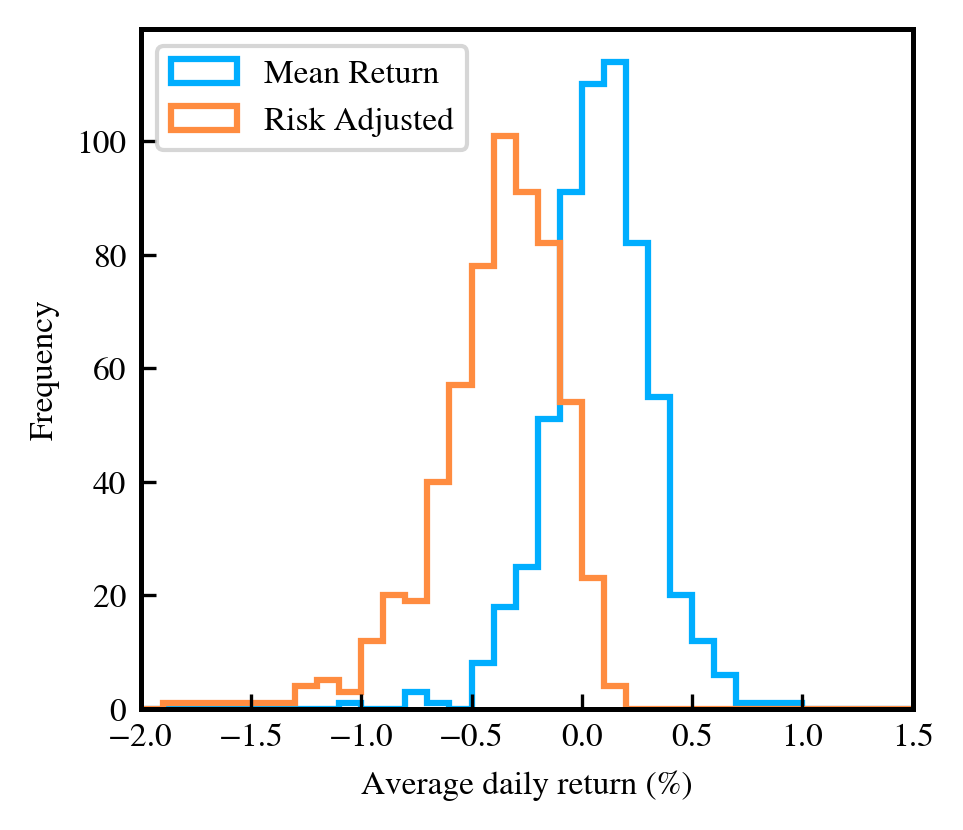

In [140]:
# Average Daily Return
bins = np.arange(-2,2,0.1)
plt.hist(100*np.exp(Returns_60.mean(axis=0))-100,bins=bins,histtype='step',lw=1.5,label='Mean Return')
plt.hist(100*np.exp(risk_adjusted)-100,bins=bins,histtype='step',lw=1.5,label='Risk Adjusted')
plt.xlabel('Average daily return (%)')
plt.xlim(-2,1.5)
plt.ylabel('Frequency')
plt.legend(loc='upper left',frameon=True)
plt.savefig('AverageDailyReturn.pdf')


In [ ]:
Returns_60['MARKET'] = Returns_60.mean(axis=1)

In [59]:
# Method 1: (co)skewness
def coskew(df, bias=False):
    v = df.values
    s1 = sigma = v.std(0, keepdims=True)
    means = v.mean(0, keepdims=True)

    # means is 1 x n (n is number of columns
    # this difference broacasts appropriately
    v1 = v - means

    s2 = sigma ** 2

    v2 = v1 ** 2

    m = v.shape[0]

    skew = pd.DataFrame(v2.T.dot(v1) / s2.T.dot(s1) / m, df.columns, df.columns)

    if not bias:
        skew *= ((m - 1) * m) ** .5 / (m - 2)

    return skew

coskew(Returns_60)

,BT.A-GB,CCL-GB,MKS-GB,BARC-GB,ITRK-GB,BRBY-GB,NXT-GB,UDG-GB,KGF-GB,ITV-GB,...,KBX-DE,ALC-CH,PHNX-GB,ADE-NO,NEXI-IT,TRN-GB,BCVN-CH,PRX-NL,FDJ-FR,MARKET
BT.A-GB,0.135970,-0.172813,-0.176644,-0.000846,-0.752876,-0.573932,-0.398202,-0.397438,-0.130671,-0.193355,...,-0.575218,-0.142197,-0.221702,-0.327767,-0.012962,-0.114595,-0.081212,-0.088506,-0.480362,-0.151887
CCL-GB,0.051698,0.236286,0.345383,0.212500,0.191005,-0.388728,0.034135,0.107621,-0.226688,0.178523,...,0.134775,0.383723,0.133095,-0.051198,-0.157086,-0.173014,-0.082376,-0.053320,-0.071614,0.181041
MKS-GB,-0.150913,0.199529,0.194311,0.067328,-0.073694,0.229183,0.032808,-0.068184,0.036331,-0.120860,...,-0.216233,-0.248733,-0.196915,-0.337485,-0.057609,-0.141884,-0.283215,-0.096198,0.133016,-0.149948
BARC-GB,-0.087777,0.155107,-0.004176,-0.271040,0.072970,0.064818,0.200727,-0.279063,-0.114816,-0.067784,...,-0.166949,0.012364,-0.218963,-0.183080,-0.026054,-0.237968,-0.212720,-0.024758,0.040960,-0.124841
ITRK-GB,-0.162378,0.287006,0.196823,0.384736,0.222910,-0.318616,0.275941,0.279671,0.072757,0.221052,...,0.164308,0.366813,0.311066,0.156301,-0.010422,-0.207413,0.087635,0.022141,-0.144270,0.303007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRN-GB,-0.218253,-0.346607,-0.227449,-0.255796,0.278743,-0.161882,-0.249773,-0.002257,-0.119697,-0.449706,...,0.133741,-0.059910,-0.269324,0.601855,-0.170684,-0.365816,0.204433,0.285196,-0.114426,-0.114258
BCVN-CH,-0.093077,-0.159649,-0.162860,-0.262403,-0.027846,-0.048977,-0.283588,0.011615,-0.273679,-0.057455,...,0.112176,-0.353142,-0.380739,-0.172222,-0.237830,-0.068657,-0.234676,-0.318003,-0.057423,-0.277383
PRX-NL,-0.000021,0.205084,0.108965,0.115008,-0.052115,-0.082615,-0.163674,-0.184507,0.220832,-0.133512,...,0.090023,-0.226898,-0.080220,-0.048246,-0.289692,-0.060070,0.005480,-0.066553,0.055288,-0.085022
FDJ-FR,-1.059530,-0.342472,-1.187198,-1.182193,-0.280612,-0.481007,-1.006333,-0.988132,-0.693755,-0.808303,...,-0.662396,-1.368014,-0.695436,-0.399652,-0.188512,0.497046,-1.169160,-0.882403,4.367038,-1.687818


In [60]:
# Select 60 stocks with lowest coskewness wrt market
SKEW_60 = coskew(Returns_60)['MARKET'].sort_values().iloc[:60].index

In [61]:
# Method 2: TK values
alpha_ = 0.88
lambda_ = 2.25
gamma_ = 0.61
delta_ = 0.69

def v_up(x):
    return x**alpha_
def v_down(x):
    return -lambda_*(-x)**alpha_

def w_up(P):
    return P**gamma_ / ((P**gamma_ + (1-P)**gamma_)**(1/gamma_))
def w_down(P):
    return P**delta_ / ((P**delta_ + (1-P)**delta_)**(1/delta_))

def get_TK(Returns):
    
    TKvals = []
    for stock in Returns.columns:
        ret_data = Returns[stock].sort_values().dropna()
        N_days = len(ret_data)
        m = (ret_data<0).sum()
        n = (ret_data>0).sum()

        ret_data_plus = ret_data[ret_data>0]
        ret_data_down = ret_data[ret_data<0]

        TK = 0
        i = -m

        for ret in ret_data_down.values.reshape(-1):
            TK += v_down(ret) * (w_down((i+m+1)/N_days) - w_down((i+m)/N_days))
            i+=1    
        i=1
        for ret in ret_data_plus.values.reshape(-1):
            TK += v_up(ret) * (w_up((n-i+1)/N_days) - w_up((n-i)/N_days))
            i+=1    
        TKvals.append(TK)
    TK = pd.DataFrame({'Stock':Returns.columns,'TK':TKvals}).set_index('Stock')
    return TK

TK = get_TK(Returns_60)

Text(0, 0.5, 'Frequency')

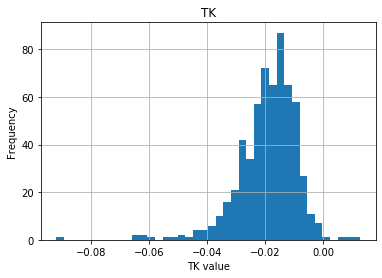

In [62]:
TK.hist(bins='auto')
plt.xlabel('TK value')
plt.ylabel('Frequency')

In [63]:
TK = TK.sort_values(by='TK')#.plot()
TK['ID'] = np.arange(0,len(TK))

In [64]:
TK_60 = TK.iloc[:60].index

In [65]:
stocks_to_choose = np.unique(np.hstack((TK_60,SKEW_60)))

In [68]:
trades_week4 = pd.DataFrame({'Stock':df_PRICES.columns.values}).set_index('Stock')
trades_week4['Weight'] = 0
trades_week4.loc[stocks_to_choose] = 1 / len(stocks_to_choose)
trades_week4.to_excel('WeightWeek4.xlsx')

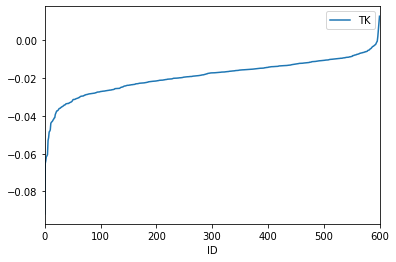

In [71]:
TK.plot(x='ID',y='TK')

In [137]:
from astropy.io import ascii
df = ascii.read('./Europe_3_Factors.txt').to_pandas()
df['Date'] = df.Date.apply(lambda x: str(x)[:4] + '/' + str(x)[4:6] + '/' + str(x)[6:])
df['Date'] = pd.to_datetime(df.Date)
df = df.set_index('Date')
df = df.rolling(window = 12).mean()
df['Date'] = df.index

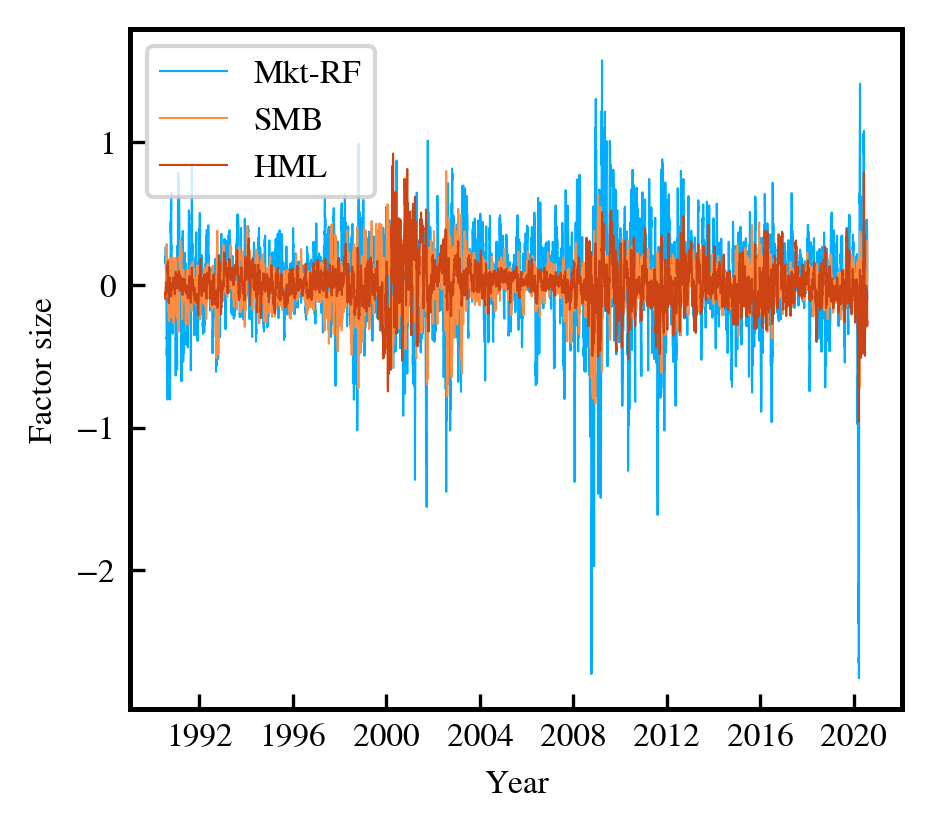

In [138]:
plt.plot(df.Date,df['Mkt-RF'].values,label='Mkt-RF',lw=0.5)
plt.plot(df.Date,df['SMB'].values,label='SMB',lw=0.5)
plt.plot(df.Date,df['HML'].values,label='HML',lw=0.5)
#plt.plot(df.Date,df['RF'].values,label='RF')
plt.ylabel('Factor size')
plt.xlabel('Year')
plt.legend(loc='upper left',frameon=True)
plt.savefig('FamaFrenchTreefac.pdf')


In [139]:
600/25

24.0